# q-space에서만 diffusion 하는 smapling 방식 실험.

In [1]:
import numpy as np
import torch

from scipy.spatial.distance import cdist, pdist
import scipy

import os
import ase.io
import ase
import sys

from torch_scatter import scatter_add

from lst_interp import *

import matplotlib.pyplot as plt
# import seaborn as sns

torch.set_num_threads(4)

## fix random seed
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    return
set_seed(0)

/home/jhwoo/.conda/envs/pysis-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Sampling Parameters study

1. $\beta_t$의 함수꼴을 sigmoid style을 사용했을 때, $t\to T$ 에서 score가 **매우** 불안정해지는 것을 확인
    - bell shaped curve를 사용하면, 여전히 튀는 현상이 발생하기는 하지만 에러 스케일이 0.01 수준으로 매우 양호해진다.
    - $t\to T$에서 $\beta$를 0 으로 수렴시켜서 update양을 조절하는게 주요하지 않았을까 생각한다.
2. $\sigma_0 = 0$ 이 되면 numerically 문제가 생긴다.
    - 왜냐하면 $(\hat{\sigma}_t)^{-1} \to \infty$ as $t\to 0$.
    - $\sigma_0 \gt 0$ 이면 $\beta_t \to 0$ 으로 만들고, $(\hat{\sigma}_t)^{-1} \lt \infty$ 로 만들 수 있어서 문제를 해결할 수 있다.

---

### $\beta(t)$ is truncated normal distribution, defined on [0, 1]
### $\sigma^2(t)=\int_0^{t}\beta(s)ds + \sigma^2(0)$ 
### $\sigma^2(0)/\int_0^{1}\beta(s)ds = 0.005$


In [62]:
class SamplingParams:
    def __init__(
        self,
        sampling_type,
        c=0.1,
        beta_std=0.125,
        sigma_max=1e-1,
        sigma_min=1e-7,
        sigma1_correction=1e-7,
    ):
        assert sampling_type in ["bell-shaped", "linear", "constant"]
        self.sampling_type = sampling_type
        print(f"Debug: sampling_type = {sampling_type}")

        if sampling_type in ["linear", "constant"]:
            # recommend c=0.1 for "linear", c=np.sqrt(0.1) for "constant"
            self.c = c
            self.sigma_min = sigma_min
            self.sigma_1 = self.sigma_square(1.0)
            self.sigma_0 = self.sigma_square(0.0)
            print(f"Debug: self.c = {self.c}")
            print("Debug: sigma_1, sigma_0 = ", self.sigma_1, self.sigma_0)
        elif sampling_type == "bell-shaped":
            self.sigma_linear_coef = 0.0
            self.beta_std = beta_std
            self.sigma_max = sigma_max
            if sigma_min is None:
                self.sigma_min = sigma_max * 5e-3
            else:
                self.sigma_min = sigma_min
            self.normalizer = 1 / (beta_std * np.sqrt(2 * np.pi))

            self.sigma_1 = self.sigma_square(1.0) + sigma1_correction
            self.sigma_0 = self.sigma_square(0.0)
            # print(self.sigma_1, self.sigma_0)
            print("Debug: std_beta, sigma_max, sigma_min = ", std_beta, sigma_max, sigma_min)
            print("Debug: sigma_1, sigma_0 = ", self.sigma_1, self.sigma_0)
        else:
            raise NotImplementedError
        return

    def beta(self, t):
        if self.sampling_type == "linear":
            b = self.c * 2 * t
        elif self.sampling_type == "constant":
            b = self.c**2 * torch.ones_like(t)
        elif self.sampling_type == "bell-shaped":
            if isinstance(t, torch.Tensor):
                b = torch.exp(-((t - 0.5) / self.beta_std) ** 2 / 2)
            else:
                b = np.exp(-((t - 0.5) / self.beta_std) ** 2 / 2)
            b = b * self.normalizer * self.sigma_max
            b += self.sigma_linear_coef
        else:
            raise NotImplementedError
        return b

    def sigma_square(self, t):
        if self.sampling_type == "linear":
            # s_sq = self.c * t**2 + 1e-4
            s_sq = self.c * t**2 + self.sigma_min
        elif self.sampling_type == "constant":
            # s_sq = self.c**2 * t + 1e-3
            s_sq = self.c**2 * t + self.sigma_min
        elif self.sampling_type == "bell-shaped":
            erf_scaler = self.sigma_max / 2 # / (self.beta_std * np.sqrt(8) * 2)
            if isinstance(t, torch.Tensor):
                s_sq = erf_scaler * (1 + torch.special.erf( (t - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
                s_sq = s_sq - erf_scaler * (1 + scipy.special.erf( (0 - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
                s_sq += self.sigma_linear_coef * t
            else:
                s_sq = erf_scaler * (1 + scipy.special.erf( (t - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
                s_sq = s_sq - erf_scaler * (1 + scipy.special.erf( (0 - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
                s_sq += self.sigma_linear_coef * t
        else:
            raise NotImplementedError
        return s_sq
        
    def SNR(self, t):
        return self.sigma_square(t) / self.sigma_1

Debug: sampling_type = linear
Debug: self.c = 0.1
Debug: sigma_1, sigma_0 =  0.10001 1e-05


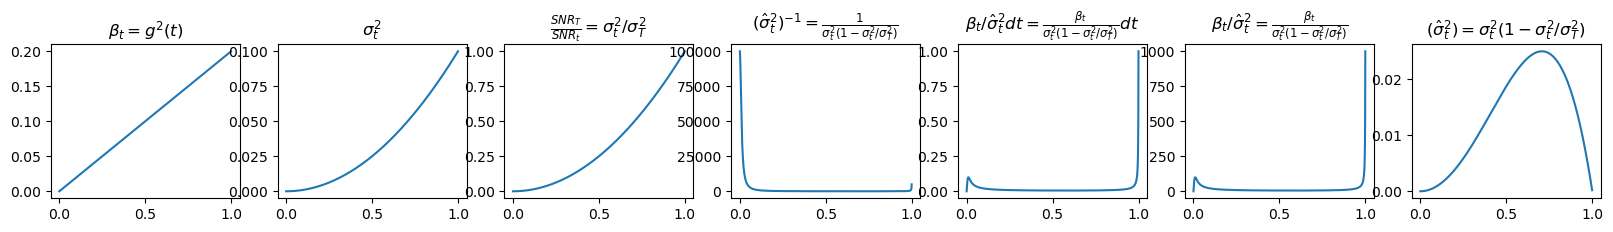

In [70]:
## Set sampling parameters

sampling_type = ["bell-shaped", "linear", "constant"][1]

if sampling_type in ["linear", "constant"]:
    # for linear and square sampling
    c = 0.1
    sigma_min = 1e-4
    std_beta = None
    sigma_min = 1e-5
    sigma1_correction = None
else:
    # bell-shaped sampling
    std_beta = 0.125
    # sigma_max = 0.1
    sigma_min = 1e-8
    sigma1_correction = 1e-8


params = SamplingParams(
    sampling_type=sampling_type,
    c=c,
    beta_std=std_beta,
    sigma_max=sigma_max,
    sigma_min=sigma_min,
    sigma1_correction=sigma1_correction,
    )

## t samples
num_time_steps = 1000
t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
# t = torch.cat(
#     (torch.linspace(0, 0.5, int(num_time_steps * 0.5)), torch.linspace(0.5, 1, int(num_time_steps * 0.5))),
#     dim=0,
# )
# dt = 
betas = params.beta(t)
sigma_square = params.sigma_square(t)
SNRTt = params.SNR(t)


## plot
fig, axs = plt.subplots(1, 7, figsize=(20, 2))
plt.subplots_adjust(hspace=0.5)
plt.rcParams.update({'font.size': 10})  # Set the global font size to 12
axs = axs.flatten()

ax = axs[0];ax.plot(t, betas);ax.set_title(r"$\beta_t = g^2(t)$")
ax = axs[1];ax.plot(t, sigma_square);ax.set_title("$\sigma_{t}^{2}$")
ax = axs[2];ax.plot(t, SNRTt);ax.set_title(r"$\frac{SNR_{T}}{SNR_{t}}=\sigma_t^2/\sigma_T^2$")
ax = axs[3];ax.set_title(r"$(\hat{\sigma}_t^2)^{-1}=\frac{1}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$");ax.plot(t, (1 / sigma_square / (1 - SNRTt)))
ax = axs[4];ax.set_title(r"$\beta_t/\hat{\sigma}_{t}^2 dt=\frac{\beta_t}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)} dt$");ax.plot(t, (betas / sigma_square / (1 - SNRTt)) * 1 / len(betas))
ax = axs[5];ax.set_title(r"$\beta_t/\hat{\sigma}_{t}^2=\frac{\beta_t}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$");ax.plot(t, (betas / sigma_square / (1 - SNRTt)))
ax = axs[6];ax.set_title(r"$(\hat{\sigma}_t^2)={\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$");ax.plot(t, (1 * sigma_square * (1 - SNRTt)))

In [77]:
## wrapper class to save atoms object
import sys
sys.path.append("/home/share/DATA/NeuralOpt/Interpolations/Geodesic_interp")
# from get_geodesic_energy import get_rijlist_and_re, compute_wij, morse_scaler
from get_geodesic_energy import morse_scaler, ATOMIC_RADIUS


class Wrapper:
    def __init__(
        self,
        atoms_0,
        atoms_T,
        q_type="DM",
        alpha=1.7,
        beta=0.01,
        gamma=0.01,
        test_least_square=False,
    ):
        self.atoms_0 = atoms_0
        self.atoms_T = atoms_T
        # assert q_type in ["DM", "morse"]
        self.q_type = q_type

        self.pos_t = torch.tensor(atoms_T.get_positions())

        self.re = torch.Tensor(self.get_re(atoms_T))
        # self.re = torch.Tensor(self.get_re(atoms_T))
        self.alpha, self.beta = alpha, beta
        self.gamma = gamma
        self.test_least_square = test_least_square
        
        self.morse_scaler = morse_scaler(self.re, self.alpha, self.beta)
        self.scaler_factor = 1.0; print(f"Debug: self.scaler_factor set to {self.scaler_factor}")
        return

    def get_re(self, atoms, threshold=np.inf):
        from scipy.spatial import KDTree

        rijset = set()
        tree = KDTree(atoms.positions)
        pairs = tree.query_pairs(threshold)
        rijset.update(pairs)
        rijlist = sorted(rijset)

        radius = np.array([ATOMIC_RADIUS.get(atom.capitalize(), 1.5) for atom in atoms.get_chemical_symbols()])
        re = np.array([radius[i] + radius[j] for i, j in rijlist])
        return re

    def pos_to_dist(self, pos):
        if self.q_type == "morse":
            rij = pdist(pos)
            wij = self.morse_scaler(rij)[0] * self.scaler_factor
            length = torch.Tensor(wij)
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        elif self.q_type == "DM":
            length = torch.Tensor(pdist(pos))
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        elif self.q_type == "morse+DM":
            rij = pdist(pos)
            wij = self.morse_scaler(rij)[0] * self.scaler_factor
            wij += self.gamma * rij
            length = torch.Tensor(wij)
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        else:
            raise NotImplementedError
        return index, length

    def reverse_diffusion_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=True):
        beta_t = params.beta(t)

        if coord == "Cartesian":
            reverse_score_, v1, v2, v3, v4 = self.reverse_score(x_t, t, params, x_0, x_T, verbose=verbose)
            # dx = (h_coeff * self.pinned_score(x_t, t, params, x_T) - 1.0 * reverse_score_) * dt 
            dx = (- 1.0 * reverse_score_) * dt 
        else:
            reverse_score_, v1, v2, v3, v4 = self.reverse_score2(x_t, t, params, x_0, x_T, verbose=verbose)
            # dx = (h_coeff * self.pinned_score2(x_t, t, params, x_T) - 1.0 * reverse_score_) * dt
            dx = (- 1.0 * reverse_score_) * dt
    
        # index, d_t = self.pos_to_dist(x_t)
        d_t = x_t
        dw_d = torch.sqrt(beta_t * dt) * torch.randn_like(d_t)
        # dw_pos = self.eq_transform(dw_d, x_t, index, d_t)
        dw_pos = dw_d
        # dw = torch.sqrt(beta_t * dt) * torch.randn_like(x_t)
        dx += dw_pos
        x_tm1 = x_t - dx

        if self.test_least_square:
            ## least_square (make q feasible)
            guess_atoms = self.atoms_T.copy()
            guess_atoms.set_positions(self.pos_t)
            q_type = "morse" if self.q_type == "morse" else "distance"
            self.pos_t = least_square(guess_atoms=guess_atoms, target_d=x_tm1, q_type=q_type)
            self.pos_t = torch.tensor(self.pos_t)
            _, x_tm1 = self.pos_to_dist(self.pos_t)

            # debugging: calculate errors
            d_0 = pdist(self.atoms_0.positions)
            d_t = pdist(self.pos_t)
            v1 = None
            v2 = torch.Tensor(d_0 - d_t).abs().mean()
            v3 = None
            v4 = None

        return x_tm1, v1, v2, v3, v4

    def reverse_ode_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=True):
        beta_t = params.beta(t)

        if coord == "Cartesian":
            reverse_score_, v1, v2, v3, v4 = self.reverse_score(x_t, t, params, x_0, x_T, verbose=verbose)
            dx = (- 0.5 * reverse_score_) * dt
        else:
            reverse_score_, v1, v2, v3, v4 = self.reverse_score2(x_t, t, params, x_0, x_T, verbose=verbose)
            dx = (- 0.5 * reverse_score_) * dt
        x_tm1 = x_t - dx
        
        if self.test_least_square:
            ## least_square (make q feasible)
            guess_atoms = self.atoms_T.copy()
            guess_atoms.set_positions(self.pos_t)
            q_type = "morse" if self.q_type == "morse" else "distance"
            self.pos_t = least_square(guess_atoms=guess_atoms, target_d=x_tm1, q_type=q_type)
            self.pos_t = torch.tensor(self.pos_t)
            if self.add_position_noise:
                self.pos_t += torch.sqrt(beta_t * dt) * torch.randn_like(self.pos_t)  # test: noise to position
            _, x_tm1 = self.pos_to_dist(self.pos_t)
            
            # debugging: calculate errors
            d_0 = pdist(self.atoms_0.positions)
            d_t = pdist(self.pos_t)
            v1 = None
            v2 = torch.Tensor(d_0 - d_t).abs().mean()
            v3 = None
            v4 = None
            
        return x_tm1, v1, v2, v3, v4

    def reverse_score2(self, x_t, t, params, x_0, x_T, verbose=True):
        # calculate parameters
        beta_t = params.beta(t)
        sigma_t_square = params.sigma_square(t)
        sigma_T_square = params.sigma_1

        SNRTt = params.SNR(t)
        sigma_t_hat_square = sigma_t_square * (1 - SNRTt)

        # calc mu_hat
        typo = 2
        # typo = 3; print("Debug: using LST", end="")
        if typo == 1:
            mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)
            _, d_mu_hat = self.pos_to_dist(mu_hat)
        if typo == 2:
            _, d_0 = self.pos_to_dist(x_0)
            _, d_T = self.pos_to_dist(x_T)
            d_mu_hat = d_T * SNRTt + d_0 * (1 - SNRTt)
            mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)  # for debugging
        if typo == 3:
            mu_hat = interpolate_LST(x_0.numpy(), x_T.numpy(), SNRTt.item())
            _, d_mu_hat = self.pos_to_dist(mu_hat)

        # calc difference
#         index, d_t = self.pos_to_dist(x_t)
        d_t = x_t
        diff_d = d_mu_hat - d_t
#         diff_pos = self.eq_transform(diff_d, x_t, index, d_t)
        diff_pos = diff_d

        # calc score
        coeff =  2 / (sigma_t_hat_square) * beta_t
        score = diff_pos * coeff

        # for debugging
        v1 = (d_mu_hat - d_t).abs().mean()
        v2 = (d_0 - d_t).abs().mean()
        v3 = None
        v4 = None

        if verbose:
            print(f"{t:0.3f}\t{v1:0.4f}\t\t{v2:0.4f}\t\t{v3:0.4f}\t\t{v4:0.4f}\t\t{torch.linalg.norm(score, dim=-1).max():0.4f}")
        return score, v1, v2, v3, v4

In [72]:
atoms_0 = list(ase.io.iread("wb97xd3/wb97xd3_rxn_ts.xyz"))
# atoms_T = list(ase.io.iread("wb97xd3/wb97xd3_rxn_r.xyz"))
# atoms_T = list(ase.io.iread("pm7/pm7_rxn_r.xyz"))
atoms_T = list(ase.io.iread("pm7/pm7_rxn_ts.xyz"))
# atoms_T = list(ase.io.iread("wb97xd3_geodesic/wb97xd3_geodesic_rxn_ts.xyz"))

def experiment1(
    idx,
    sampling_type,
    coord_type,
    h_coeff,
    num_time_steps=200,
    verbose=False,
    plot=True,
    q_type="morse",
    test_least_square=False,
    add_position_noise=False,
):
    set_seed(0)

    # find matched index
    xT = atoms_T[idx]
    file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
    gt_idx = int(file_name[2:])
    x0 = atoms_0[gt_idx]
    
    # gamma = 0.8
    gamma = 0.0
    alpha, beta = 1.7, 0.01
    alpha *= (1 - gamma)
    beta *= (1 - gamma)
    # alpha, beta = 1.5, 0.2
    print(f"Debug: alpha, beta = {alpha}, {beta}")
    wrapper = Wrapper(x0, xT, q_type=q_type, alpha=alpha, beta=beta, gamma=gamma, test_least_square=test_least_square)
    # wrapper.scaler_factor = 2.; print(f"Debug: wrapper.scaler_factor set to {wrapper.scaler_factor}")
    wrapper.add_position_noise = add_position_noise; print(f"Debug: wrapper.add_position_noise set to {add_position_noise}")

    pos0 = torch.Tensor(x0.get_positions())
    posT = torch.Tensor(xT.get_positions())
    # posT = pos0 + torch.randn_like(pos0) * 0.05; print(f"Debug: random noised pos0 is used as posT.")

    t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
    dt = (t[1:] - t[:-1]).mean()

    torch.set_printoptions(precision=6, sci_mode=False)
    reverse_traj = [posT]
    x = posT
    v1s = []
    v2s = []
    v3s = []
    v4s = []

    _, x = wrapper.pos_to_dist(x)

    if verbose:
        print(f"(Debug) mu_d - d_t\t mu_d - d_T\t mu_x - x_t\t mu_x - x_T\t score")
    for idx, i in enumerate(torch.flip(t, dims=(0,))):
        print(idx, end=" ")
        if sampling_type == "hybrid":
            if idx % 2 == 0:
                x, v1, v2, v3, v4 = reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
            else:
                x, v1, v2, v3, v4 = reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
        elif sampling_type == "ode":
            x, v1, v2, v3, v4 = wrapper.reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
        else:
            # sde
            x, v1, v2, v3, v4 = wrapper.reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)

        v1s.append(v1); v2s.append(v2); v3s.append(v3); v4s.append(v4)
        reverse_traj.append(x)

    if plot:
        label = f"{coord_type}, {sampling_type}"
        # plt.plot(v2s[::-1])
        # plt.plot(v4s[::-1])
        # plt.plot(v1s[::-1], label=label)
        plt.plot(v2s[::-1], label=label)
        # plt.plot(v3s[::-1])
        plt.xlabel(r"time step", fontsize=16)
        plt.ylabel(r"||$\hat{d}_t - d_t$||", fontsize=16)
    # # return v1s[::-1]
    return v2s[::-1]

q_type = morse
test_least_square = True
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to False
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to False
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to True
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

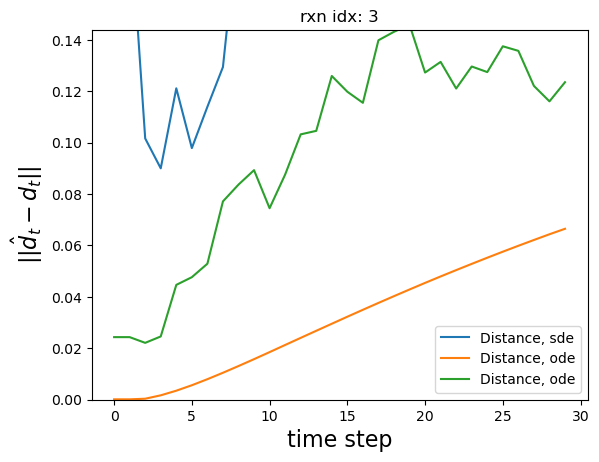

err_at_zero_t =  [0.19087252020835876, 0.0001517036434961483, 0.02434862032532692]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to False
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to False
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to True
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

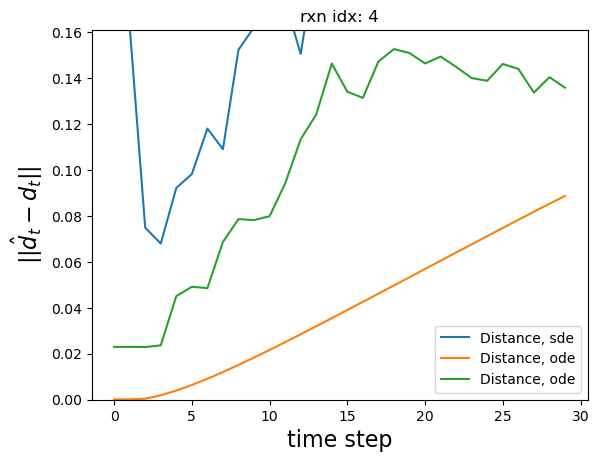

err_at_zero_t =  [0.162748321890831, 0.0001639565743971616, 0.0229897852987051]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to False
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to False
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to True
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

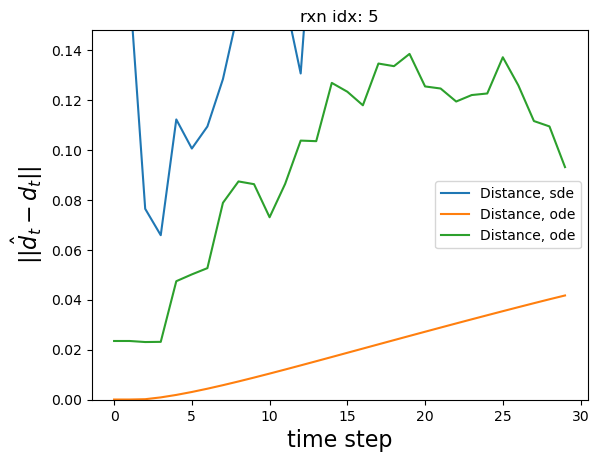

err_at_zero_t =  [0.1650930494070053, 7.945278048282489e-05, 0.023505795747041702]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to False
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to False
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to True
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

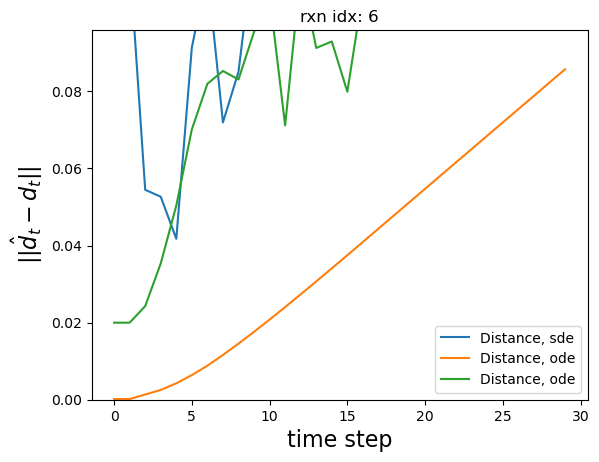

err_at_zero_t =  [0.11421504616737366, 0.00017099434626288712, 0.019983403384685516]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to False
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to False
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to True
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

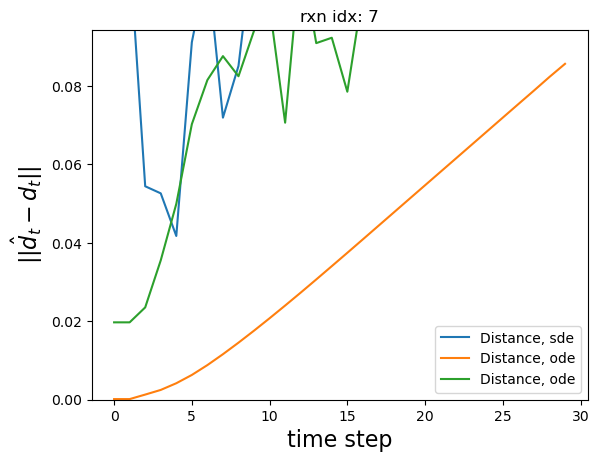

err_at_zero_t =  [0.11428800970315933, 0.000161567673785612, 0.019735969603061676]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to False
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to False
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to True
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

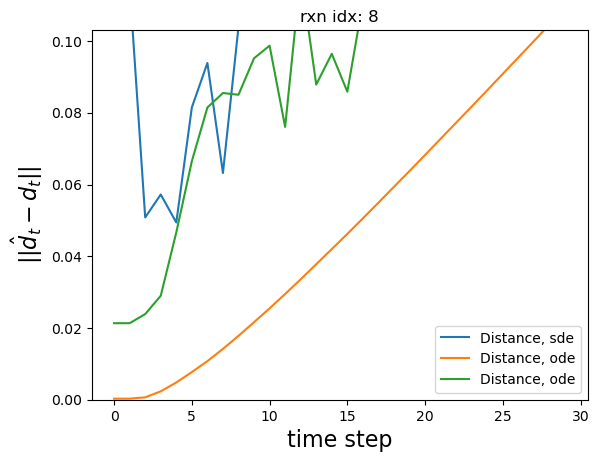

err_at_zero_t =  [0.1155235767364502, 0.0002942347200587392, 0.02133658155798912]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to False
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to False
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to True
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

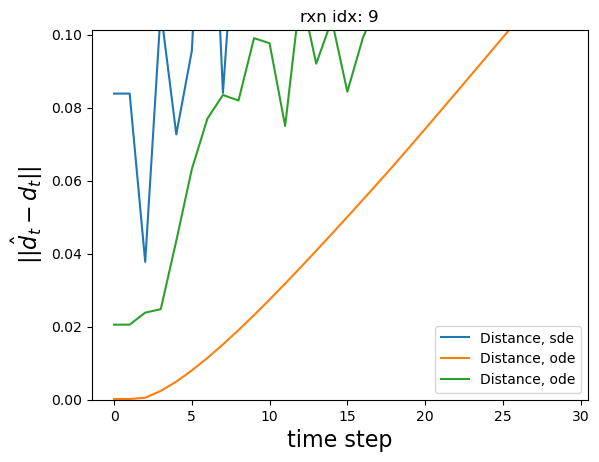

err_at_zero_t =  [0.08384278416633606, 0.0002041413536062464, 0.020557185634970665]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to False
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to False
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: wrapper.add_position_noise set to True
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

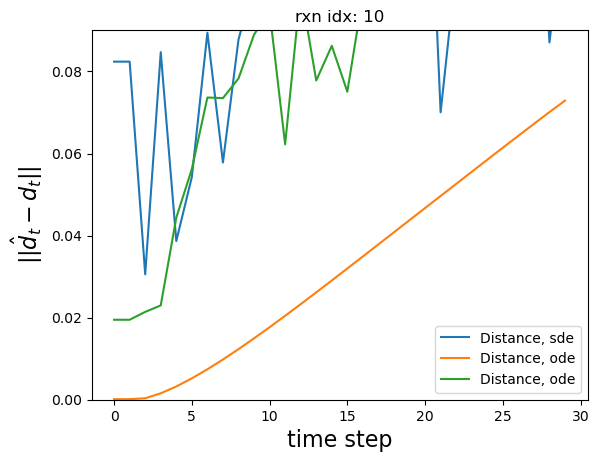

err_at_zero_t =  [0.08239634335041046, 0.00013323283928912133, 0.019491808488965034]
Done!


In [78]:
"""
sampling_type: "sde", "ode", "hybrid"
coord_type: "Cartesian", "Distance"
"""
num_time_steps = 500
num_time_steps = 200
num_time_steps = 50
# num_time_steps = 300
num_time_steps = 30
# num_time_steps = 20

h_coeff = 0.0
verbose = True
verbose = False
q_type = "DM"
q_type = "morse"
# q_type = "morse+DM"
print(f"q_type = {q_type}")

test_least_square = True
print(f"test_least_square = {test_least_square}")

for idx in [3,4,5,6,7,8,9,10]:
# for idx in [60, 320]:
# for idx in [42,60,78,238,304,344,458,718,746,774,884,913]:
# for idx in [42, 60]:
# for idx in [42,60,78,238,304]:
# for idx in [78,238]:
# for idx in np.random.randint(0, 999, size=10):
    # idx = idx + 50
    err_at_zero_t = []
    v = experiment1(idx, "sde", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type, test_least_square=test_least_square)
    err_at_zero_t.append(v[0].item())
    v = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type, test_least_square=test_least_square)
    err_at_zero_t.append(v[0].item())
    v = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type, test_least_square=test_least_square, add_position_noise=True)
    err_at_zero_t.append(v[0].item())
    
    # plt.ylim(0.0)
    plt.ylim(0.0, v[num_time_steps//2] * 1.2)
    plt.title(f"rxn idx: {idx}")
    plt.legend()
    plt.show()
    print("err_at_zero_t = ", err_at_zero_t)
print("Done!")

# =============================================================